<a href="https://colab.research.google.com/github/nickschizas/numer-ai/blob/main/v5_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Runtime > Change runtime type > TPU v2`

In [1]:
%%time
!pip install numerapi
!pip install numerai-tools
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 880.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 28.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.1.3 which is incompatible.
CPU times: user 99.8 ms, sys: 32.8 ms, total: 133 ms
Wall time: 16.8 s


In [135]:
from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import pandas as pd
import json

import matplotlib.pyplot as plt

api = NumerAPI()

## Download v5.0 data

In [4]:
%%time
VERSION = 5.0
datasets = [dataset for dataset in api.list_datasets() if (dataset.startswith(f'v{VERSION}')) & ~("example" in dataset)]
datasets

CPU times: user 9.9 ms, sys: 0 ns, total: 9.9 ms
Wall time: 310 ms


['v5.0/features.json',
 'v5.0/train.parquet',
 'v5.0/train_benchmark_models.parquet',
 'v5.0/validation.parquet',
 'v5.0/validation_benchmark_models.parquet']

In [5]:
%%time
for dataset in datasets:
  api.download_dataset(dataset)

v5.0/features.json: 480kB [00:00, 2.21MB/s]                           
v5.0/train.parquet: 2.37GB [01:53, 20.8MB/s]                            
v5.0/train_benchmark_models.parquet: 81.7MB [00:04, 19.2MB/s]                            
v5.0/validation.parquet: 3.18GB [02:57, 18.0MB/s]                            
v5.0/validation_benchmark_models.parquet: 133MB [00:06, 22.1MB/s]                           

CPU times: user 50.6 s, sys: 10.5 s, total: 1min 1s
Wall time: 5min 3s


## Read data

### features

In [25]:
%%time
feature_metadata = json.load(open("v5.0/features.json"))
print(feature_metadata.keys())


for i in list(feature_metadata["feature_sets"].keys()):
  print(f"{i}, {len(feature_metadata['feature_sets'][i]):,.0f}")

dict_keys(['feature_sets', 'targets', 'v43_to_v5_map'])
small, 42
medium, 705
all, 2,376
v2_equivalent_features, 304
v3_equivalent_features, 1,000
fncv3_features, 400
intelligence, 35
charisma, 290
strength, 135
dexterity, 51
constitution, 335
wisdom, 140
agility, 145
serenity, 95
sunshine, 325
rain, 666
midnight, 244
CPU times: user 5.21 ms, sys: 0 ns, total: 5.21 ms
Wall time: 4.63 ms


### benchmarks

In [136]:
def transform_dataframe(dataframe):
  # make era column integer
  dataframe.loc[:, "era"] = dataframe.loc[:, "era"].astype(int)
  # keep every 4th era to prevent overlapping of 20 days targets
  dataframe = dataframe[dataframe.era.isin(dataframe.era.unique()[::4])]
  return dataframe

In [137]:
%%time
train_bench = pd.read_parquet("v5.0/train_benchmark_models.parquet")
val_bench = pd.read_parquet("v5.0/validation_benchmark_models.parquet")
train_target = pd.read_parquet("v5.0/train.parquet", columns=["era", "target"])
val_target = pd.read_parquet("v5.0/validation.parquet", columns=["era", "target"])

train_bench = transform_dataframe(train_bench)
val_bench = transform_dataframe(val_bench)

train_target.era = train_target.era.astype(int)
val_target.era = val_target.era.astype(int)

train_target = train_target[train_target.era >= min(train_bench.era)]
train_target = transform_dataframe(train_target)

val_target = val_target[val_target.era >= min(val_bench.era)]
val_target = transform_dataframe(val_target)

# attach target to validation benchmarks for evaluation
train_bench["target"] = train_target["target"]
val_bench["target"] = val_target["target"]
val_bench.dropna(inplace=True)

CPU times: user 6.7 s, sys: 1.67 s, total: 8.37 s
Wall time: 7.02 s


### train benchmarks performance

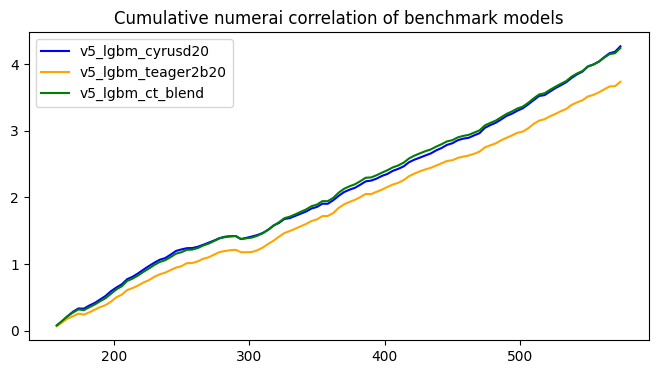

CPU times: user 9.06 s, sys: 252 ms, total: 9.31 s
Wall time: 9.02 s


In [134]:
%%time
colors = ["blue", "orange", "green"]

plt.figure(figsize=(8,4))
for i, col in enumerate(train_bench.columns[1:4]):
  per_era_corr = train_bench.groupby("era").apply(lambda x: numerai_corr(x[[col]].dropna(), x["target"].dropna()))
  plt.plot(per_era_corr.cumsum(), label=col, color=colors[i])
plt.legend()
plt.title("Cumulative numerai correlation of benchmark models")
plt.show()

In [153]:
%%time
# Compute performance metrics

for i, col in enumerate(train_bench.columns[1:4]):
  per_era_corr = train_bench.groupby("era").apply(lambda x: numerai_corr(x[[col]].dropna(), x["target"].dropna()))

  corr_mean = per_era_corr.mean()
  corr_std = per_era_corr.std(ddof=0)
  corr_sharpe = corr_mean / corr_std
  corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

  print(f"{col}")
  print(f"corr_mean {corr_mean.values[0]:,.5f}")
  print(f"corr_std {corr_std.values[0]:,.5f}")
  print(f"corr_sharpe {corr_sharpe.values[0]:,.5f}")
  print(f"corr_max_drawdown {corr_max_drawdown.values[0]:,.5f}")
  print("\n")


v5_lgbm_cyrusd20
corr_mean 0.04067
corr_std 0.02038
corr_sharpe 1.99597
corr_max_drawdown 0.04705


v5_lgbm_teager2b20
corr_mean 0.03560
corr_std 0.01794
corr_sharpe 1.98431
corr_max_drawdown 0.03581


v5_lgbm_ct_blend
corr_mean 0.04042
corr_std 0.01989
corr_sharpe 2.03230
corr_max_drawdown 0.04411


CPU times: user 9.03 s, sys: 29.4 ms, total: 9.06 s
Wall time: 9.04 s


### validation benchmarks performance

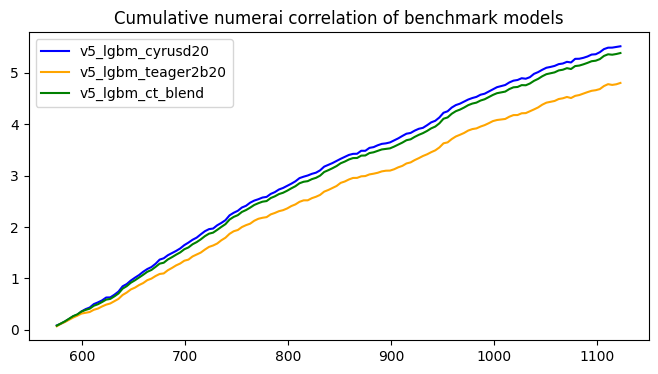

CPU times: user 13.6 s, sys: 257 ms, total: 13.9 s
Wall time: 13.6 s


In [154]:
%%time
colors = ["blue", "orange", "green"]

plt.figure(figsize=(8,4))
for i, col in enumerate(val_bench.columns[1:4]):
  per_era_corr = val_bench.groupby("era").apply(lambda x: numerai_corr(x[[col]].dropna(), x["target"].dropna()))
  plt.plot(per_era_corr.cumsum(), label=col, color=colors[i])
plt.legend()
plt.title("Cumulative numerai correlation of benchmark models")
plt.show()

In [155]:
%%time
# Compute performance metrics

for i, col in enumerate(val_bench.columns[1:4]):
  per_era_corr = val_bench.groupby("era").apply(lambda x: numerai_corr(x[[col]].dropna(), x["target"].dropna()))

  corr_mean = per_era_corr.mean()
  corr_std = per_era_corr.std(ddof=0)
  corr_sharpe = corr_mean / corr_std
  corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

  print(f"{col}")
  print(f"corr_mean {corr_mean.values[0]:,.5f}")
  print(f"corr_std {corr_std.values[0]:,.5f}")
  print(f"corr_sharpe {corr_sharpe.values[0]:,.5f}")
  print(f"corr_max_drawdown {corr_max_drawdown.values[0]:,.5f}")
  print("\n")

v5_lgbm_cyrusd20
corr_mean 0.03998
corr_std 0.02033
corr_sharpe 1.96635
corr_max_drawdown 0.01215


v5_lgbm_teager2b20
corr_mean 0.03481
corr_std 0.01741
corr_sharpe 1.99924
corr_max_drawdown 0.02066


v5_lgbm_ct_blend
corr_mean 0.03903
corr_std 0.01880
corr_sharpe 2.07537
corr_max_drawdown 0.01641


CPU times: user 13.3 s, sys: 12.4 ms, total: 13.3 s
Wall time: 13.2 s


## LGBMRegressor

In [182]:
feature_set = feature_metadata['feature_sets']["intelligence"]

train = pd.read_parquet("v5.0/train.parquet", columns=["era", "target"] + feature_set)
train = transform_dataframe(train)

validation = pd.read_parquet("v5.0/validation.parquet", columns=["era", "target"] + feature_set)
validation = transform_dataframe(validation)

In [158]:
from lightgbm import LGBMRegressor

In [167]:
%%time
lgbm_000 = LGBMRegressor(verbose=-1,n_estimators=2000, learning_rate=0.01, max_depth=5, num_leaves=2**5-1, colsample_bytree=0.1)
lgbm_000.fit(train[feature_set], train["target"])

CPU times: user 10min 16s, sys: 493 ms, total: 10min 16s
Wall time: 13.2 s


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000, verbose=-1)

In [194]:
%%time
validation_val = validation[["era", "target"]]
validation_val["pred"] = lgbm_000.predict(validation[feature_set])
validation_val.dropna(inplace=True)

CPU times: user 4min 10s, sys: 64.9 ms, total: 4min 10s
Wall time: 5.63 s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


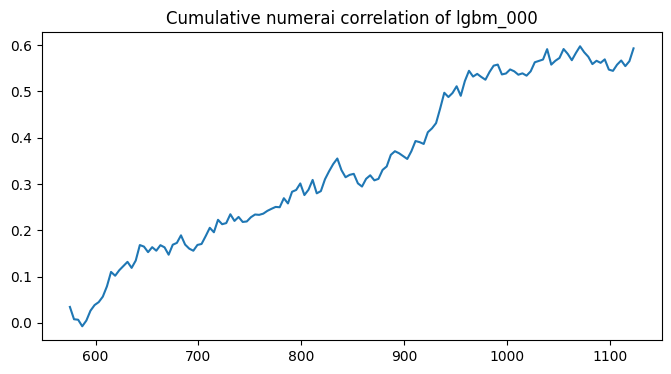

In [196]:
plt.figure(figsize=(8,4))
per_era_corr = validation_val.groupby("era").apply(lambda x: numerai_corr(x[["pred"]].dropna(), x["target"].dropna()))
plt.plot(per_era_corr.cumsum())
plt.title("Cumulative numerai correlation of lgbm_000")
plt.show()

In [199]:
per_era_corr = validation_val.groupby("era").apply(lambda x: numerai_corr(x[["pred"]].dropna(), x["target"].dropna()))

corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

print(f"corr_mean {corr_mean.values[0]:,.5f}")
print(f"corr_std {corr_std.values[0]:,.5f}")
print(f"corr_sharpe {corr_sharpe.values[0]:,.5f}")
print(f"corr_max_drawdown {corr_max_drawdown.values[0]:,.5f}")

corr_mean 0.00430
corr_std 0.01463
corr_sharpe 0.29373
corr_max_drawdown 0.06061
